In [1]:
import nltk
# nltk.download_shell()
# d
# stopwords
# q

In [2]:
msgs = [line.rstrip() for line in open('SMSSpamCollection')]
len(msgs)

5574

In [3]:
msgs[23]

'ham\tAft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?'

In [4]:
import pandas as pd
msgs = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'msg'])
msgs.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
msgs.groupby('label').describe()

msg                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [6]:
msgs['length'] = msgs['msg'].apply(len)
msgs.head()

,label,msg,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: >

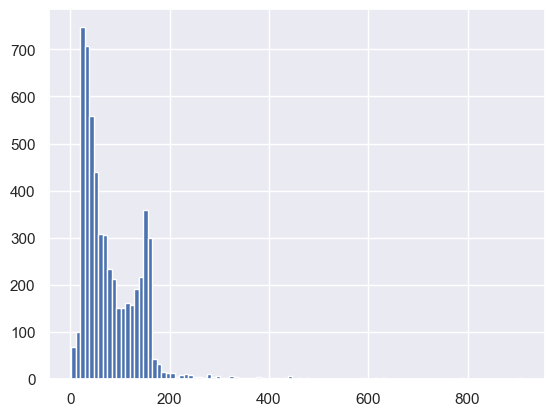

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
msgs['length'].hist(bins=100)

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

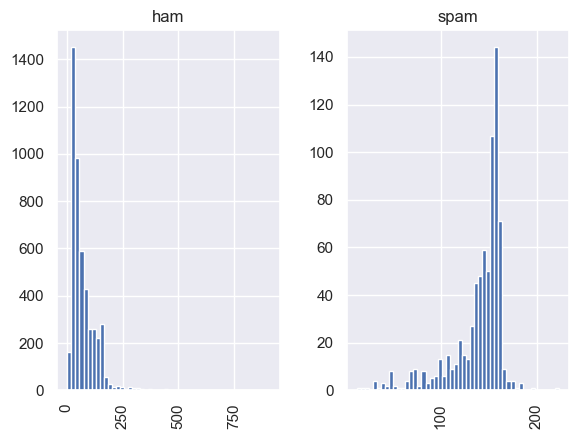

In [8]:
msgs.hist(column='length', by='label', bins=50)

In [9]:
import string
from nltk.corpus import stopwords
#stopwords.words('english')

def text_process(mess):
    no_punc = [char for char in mess if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
bow_transformer = CountVectorizer(analyzer=text_process).fit(msgs['msg'])
msgs_bow = bow_transformer.transform(msgs['msg']) # sparse matrix

tfidf_transformer = TfidfTransformer().fit(msgs_bow)
msgs_tfidf = tfidf_transformer.transform(msgs_bow)

In [10]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(msgs_tfidf, msgs['label'])
pred = spam_detect_model.predict(msgs_tfidf)
pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [11]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(msgs['msg'], msgs['label'])

from sklearn.pipeline import Pipeline
pipeline = Pipeline([('bow', CountVectorizer(analyzer=text_process)),
                    ('tfidf', TfidfTransformer()),
                    ('classifier', MultinomialNB()) # random forest
                    ])
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x172fba020>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [12]:
pred = pipeline.predict(msg_test)
from sklearn.metrics import classification_report
print(classification_report(label_test, pred))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1202
        spam       1.00      0.70      0.82       191

    accuracy                           0.96      1393
   macro avg       0.98      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393

